In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import math

In [783]:
jupyter nbconvert Olist_Satisfaction_Improvement.ipynb --to slides --post serve \
--no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output

SyntaxError: invalid syntax (3985455030.py, line 1)

In [2]:
# Load data
import os
from olist.data import Olist
data=Olist().get_data()
# get the names of the datasets
data.keys()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

### Motivations (can skip ): How is review_score contributed overall?

In [3]:
review_df=data['order_reviews']


Yes since the answer_timestamp has no missing values

In [4]:

grouped_df=review_df.groupby('review_score')[['review_id']].count()
grouped_df.rename(columns={'review_id': 'count'},inplace=True)
grouped_df



,count
review_score,
1,11424
2,3151
3,8179
4,19142
5,57328


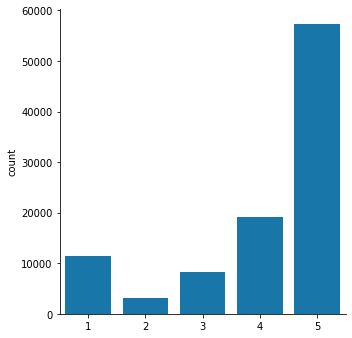

In [5]:
## plot the score 
p=sns.catplot(x=list(grouped_df.index),data=grouped_df,y='count',kind='bar',palette=sns.color_palette('winter_r',1))# need to covert into a list
#dir('FacetGrid') get attribute of a FaceGrid object
p.set(xlabel=''); # clean the x label

###  (can skip) How are the review_score contribute to sales of year 2018

In [6]:
# Code logict
# Extract data
order_df=data['order_reviews'][['order_id','review_score'] ]
order_df.drop_duplicates(inplace=True)

#some orders have multiple scores by checking nunique of the order_id. Maybe the score has been improved\
# or maybe the customers bought different products from different sellers within one order.
# We take max for such orders (we can also take mean, but for simplicity we take max)See Section 2.1 for details.
grouped_order_df=order_df.groupby('order_id')[['review_score']].max()
grouped_order_df.reset_index(inplace=True)
grouped_order_df['review_score'].unique()


payment_df=data['order_payments']
# some orders are duplicate
grouped_payment_df=payment_df.groupby('order_id')[['payment_value']].sum()


#order_df[['order_approved_at','order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']]\
#=order_df[['order_approved_at','order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']].apply(lambda x : pd.to_datetime(x,errors='raise'))

#order_payment=pd.merge(grouped_payment_df,grouped_order_df,on='order_id',how='left') #some order has no reviews 
order_payment=pd.merge(grouped_payment_df,grouped_order_df,on='order_id',how='inner') #some order has no reviews
#order_payment.info()
#order_payment.info()
#order_payment['order_id'].nunique()


order_payment['order_purchase_timestamp']=data['orders']['order_purchase_timestamp']


# Convert the date_time 
## df.loc[["col1", "col2", "col3"]] = df[["col1", "col2", "col3"]].apply(lambda x : x.to_datetime(errors='raise'))
order_payment['order_purchase_timestamp']=pd.to_datetime(order_payment['order_purchase_timestamp'],errors='ignore').dt.year
order_payment.sort_values(by='order_purchase_timestamp',ascending=False,inplace=True)
order_payment.rename(columns={'order_purchase_timestamp':'year'},inplace=True)
#order_payment['review_score'].unique()

# group data by year
year_score_payment=order_payment.groupby(['year','review_score'])[['payment_value']].sum()
year_score_payment
year_score_payment.reset_index(inplace=True)
year_score_payment
# Pivot data
year_score_payment_pivot=year_score_payment.pivot('year','review_score','payment_value')
#year_score_payment_pivot

/Users/yayahuo/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


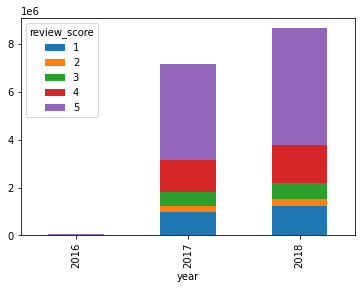

In [7]:
# Plot your graph!
year_score_payment_pivot.plot.bar(stacked=True);

Remember, some of the 5's might come from even lower scores! As we took the max of each order, so don't be too optimistic!

# The Question: 

## How to increase customer satisfaction (so as to increase profit margin) while maintaining a healthy order volume?


## We recommend:

- Action 1: cut off consistently bad performing sellers while giving them several months of honeymoon



- Action 2: Boost sales/increase prices in certain categories, removing worst performing products if necessary 



In [49]:
#download data
from olist.seller_updated import Seller
from olist.order_solution import Order
from olist.data import Olist
seller=Seller().get_training_data()



### Action 1: cut off consistently bad performing sellers after several months of honeymoon 


How is profit related to other quantities?

In [9]:
# Invesitgate correlations inparticular profits vs score vs IT_cost
#seller[['review_score','profit','IT_cost']].corr().style.background_gradient(cmap='coolwarm')
seller.corr().style.background_gradient(cmap='coolwarm')

,delay_to_carrier,wait_time,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits,IT_cost
delay_to_carrier,1.000000,0.465205,-0.084241,0.346948,-0.197933,-0.314663,-0.029257,-0.045109,-0.044400,0.031106,-0.036824,-0.055792,-0.029888,-0.087450
wait_time,0.465205,1.000000,0.069197,0.403919,-0.305907,-0.414483,0.047314,0.014792,0.015670,0.006041,0.039995,0.054158,0.000447,0.013075
months_on_olist,-0.084241,0.069197,1.000000,-0.010003,-0.044270,-0.020279,0.371743,0.403276,0.399137,-0.007920,0.377703,0.611506,0.250454,0.650506
share_of_one_stars,0.346948,0.403919,-0.010003,1.000000,-0.501308,-0.865750,0.045589,-0.013146,-0.009941,0.083295,-0.003197,-0.005620,-0.076312,-0.025127
share_of_five_stars,-0.197933,-0.305907,-0.044270,-0.501308,1.000000,0.816508,-0.063758,-0.018925,-0.020983,-0.018934,-0.017423,-0.027672,0.059552,-0.024812
review_score,-0.314663,-0.414483,-0.020279,-0.865750,0.816508,1.000000,-0.067490,-0.004031,-0.007250,-0.063526,-0.008545,-0.013158,0.084458,-0.000344
cost_of_reviews,-0.029257,0.047314,0.371743,0.045589,-0.063758,-0.067490,1.000000,0.961199,0.963295,-0.010944,0.762530,0.758949,-0.502615,0.829966
n_orders,-0.045109,0.014792,0.403276,-0.013146,-0.018925,-0.004031,0.961199,1.000000,0.993438,-0.022247,0.798981,0.799203,-0.390572,0.879755
quantity,-0.044400,0.015670,0.399137,-0.009941,-0.020983,-0.007250,0.963295,0.993438,1.000000,-0.003549,0.795229,0.794802,-0.399581,0.872093
quantity_per_order,0.031106,0.006041,-0.007920,0.083295,-0.018934,-0.063526,-0.010944,-0.022247,-0.003549,1.000000,-0.023534,-0.022398,-0.013209,-0.040766


👀 Observations

-The top 4 important factors to profits are: 


   -cost_of_reviews(of course!) 
    
    
   -quantity
    
    
   -number of orders
    
    
   -***months on olist***  


We also did a regression model for further investigation to find factors to find important factors to Profit. Relevant features:



In [10]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

seller.columns


Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
       'share_of_one_stars', 'share_of_five_stars', 'review_score',
       'cost_of_reviews', 'n_orders', 'quantity', 'quantity_per_order',
       'sales', 'revenues', 'profits', 'IT_cost'],
      dtype='object')

In [11]:
features=['delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
       'n_orders', 'quantity', 'quantity_per_order', 'sales',
       'share_of_five_stars', 'share_of_one_stars', 'review_score',
        'cost_of_reviews', 'revenues', 'IT_cost']

seller_std=standardize(seller, features)

model8=smf.ols(formula='profits~ delay_to_carrier+wait_time+months_on_olist+\
               n_orders+quantity+quantity_per_order+share_of_five_stars+sales+\
               share_of_one_stars+review_score+IT_cost',data=seller_std).fit()


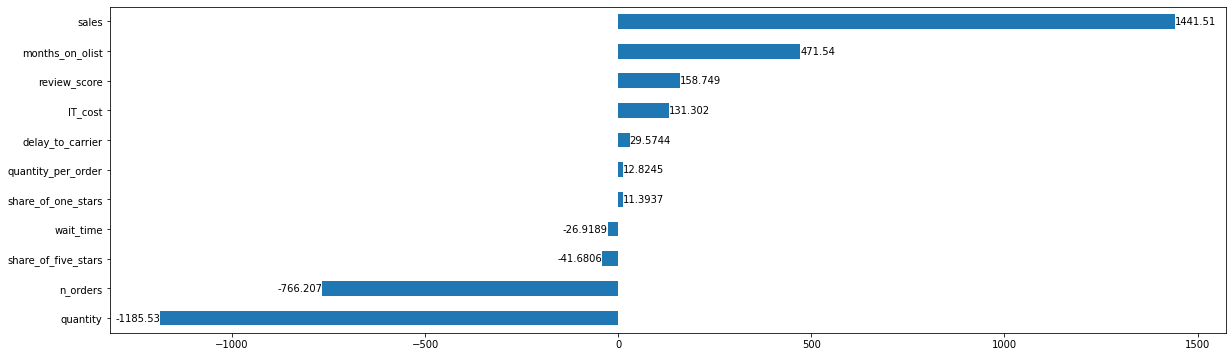

In [12]:
plt.figure(figsize=(20,6))
ax=model8.params[1:].sort_values().plot(kind='barh')
ax.bar_label(ax.containers[0]);

👀Observations:

1.share_of_one_star might not be relevant

2.the top five important features are:

sales (+1441.51)

quantity(-)

number of orders (+)

months on olist (-471.54)

review_score (+158.749)

Validate the model



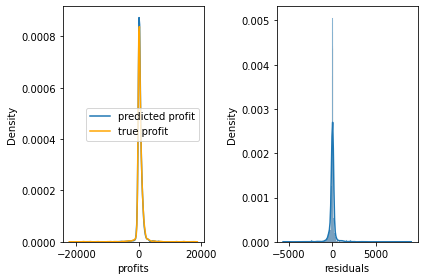

In [13]:
profit_pred = model8.predict(seller_std[features])
profit_true = seller_std['profits']
plt.subplot(1,2,1)
sns.kdeplot(profit_pred, label='predicted profit')
sns.kdeplot(profit_true, label='true profit', color='orange')
plt.legend();

plt.subplot(1,2,2)
residuals = profit_pred - profit_true
sns.histplot(residuals, stat='density', kde=True, bins=1000)
plt.xlabel('residuals');
plt.tight_layout()

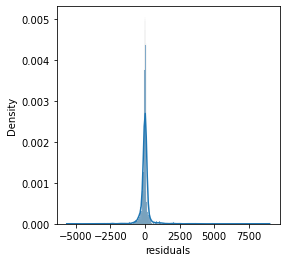

In [14]:
# Plot the residuals (differences between our predictions and the true value)
fig = plt.figure(figsize=(4, 4))
residuals = profit_pred - profit_true
sns.histplot(residuals, stat='density', kde=True, bins=1000)
plt.xlabel('residuals');
#plt.xlim(left=-2000,right=2000);

Most of the residuals are gathered around 0, so model works!

In [15]:
# Print rsqured value of the model (the closer to 1 the better)
model8.rsquared

0.8504484857784589

Interpretations of the coefficients


In [16]:
# Change numerical format (defualt scientific notation, hard to read)
pd.options.display.float_format = '{:.3f}'.format

In [17]:
pd.DataFrame([model8.params,model8.pvalues]).T.rename(columns={0:'coef',1:'p-value'})

,coef,p-value
Intercept,393.532,0.000
delay_to_carrier,29.574,0.004
wait_time,-26.919,0.012
months_on_olist,471.540,0.000
n_orders,-766.207,0.000
quantity,-1185.526,0.000
quantity_per_order,12.825,0.158
share_of_five_stars,-41.681,0.058
sales,1441.507,0.000
share_of_one_stars,11.394,0.655


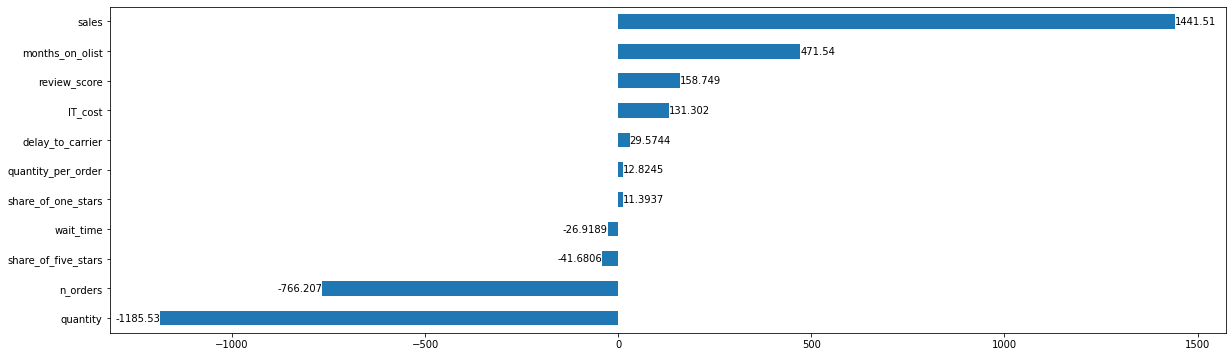

In [18]:
plt.figure(figsize=(20,6))
ax=model8.params[1:].sort_values().plot(kind='barh')
ax.bar_label(ax.containers[0]);

👀Observations:
   
   
  1.share_of_one_star might not be relevant
  
  
  2.the top five important features are: 
  
  - **sales** (+1441.51)
  
  - quantity(-)
  
  - number of orders (+)
  
  - **months on olist** (-471.54)
  
  - review_score	(+158.749)
  
  

### How do we do that?

- Give each seller several months of honeymoon (probation)

- Evaluate their performance by the end of their honeymoons

- Cut off consistently **bad-performing sellers**:
 
   -having profit<0
   
   **or**
   
   -with average score < certain threshold (e.g. 1.5)


How long is the honeymoon?

- 3 months, 6 months, 8 months, 10 months, 12 months, 14 months, or 18 months?



What score is considered "bad"?

- average score <1.5, <  2.5,  <  3.5 or  <  4?




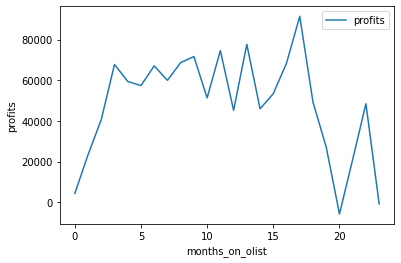

In [19]:
seller[['months_on_olist','profits']].groupby('months_on_olist').sum().plot()
total_profits=seller['profits'].sum()
plt.ylabel('profits');

Reasonable choices for honeymoon: 3 months, 6 months, 8 months, 10 months, 12 months, 14 months, 

What score is considered "bad"?

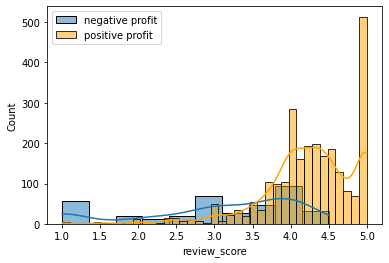

In [20]:
seller_neg=seller[seller['profits']<0]
seller_pos=seller[seller['profits']>=0]
# Get the total number of orders from
sns.histplot(seller_neg['review_score'],kde=1,label='negative profit')
sns.histplot(seller_pos['review_score'],kde=True,label='positive profit',color='orange')
plt.legend();

In [21]:
s1=seller_neg[['review_score']].describe()
s2=seller_pos[['review_score']].describe()
s=pd.concat([s1,s2],axis=1)
s.columns=['score_of_neg_sellers','score_of_pos_sellers']
s

,score_of_neg_sellers,score_of_pos_sellers
count,376.000,2591.000
mean,3.036,4.256
std,1.061,0.620
min,1.000,1.000
25%,2.500,4.000
50%,3.298,4.310
75%,3.917,4.714
max,4.500,5.000


Maybe those with an average score $<$ 2.5, $<$ 3.5 or $<$ 4 should be filtered?

In [22]:
months=[3,6,8,10,12,14,18]
scores=[1.5,2.5,3.5,4]
Seller().get_improvement_data(months,scores,'profits')

length_of_honeymoon,3,6,8,10,12,14,18
index,,,,,,,
score <=1.5,289332.182,273513.072,252985.913,242018.594,210867.829,170049.870,137546.508
score <=2.5,277498.551,264336.479,247493.513,237950.194,206799.429,165981.470,137546.508
score <=3.5,207334.148,204960.433,204147.078,203891.361,177881.796,143095.672,130309.083
score <=4,-17212.097,9984.410,31653.274,63238.651,62468.254,58113.390,95080.445


In [23]:
Seller().get_improvement_data(months,scores,'profits',Turn_on_percentage=True)

length_of_honeymoon,3,6,8,10,12,14,18
index,,,,,,,
score <=1.5,24.78%,23.43%,21.67%,20.73%,18.06%,14.56%,11.78%
score <=2.5,23.77%,22.64%,21.20%,20.38%,17.71%,14.22%,11.78%
score <=3.5,17.76%,17.55%,17.48%,17.46%,15.23%,12.26%,11.16%
score <=4,-1.47%,0.86%,2.71%,5.42%,5.35%,4.98%,8.14%


In [24]:
Seller().get_improvement_data(months,scores,'volume_reduced',Turn_on_percentage=True)

length_of_honeymoon,3,6,8,10,12,14,18
index,,,,,,,
score <=1.5,-34.29%,-32.76%,-31.04%,-29.58%,-26.40%,-21.92%,-16.45%
score <=2.5,-34.38%,-32.81%,-31.06%,-29.59%,-26.41%,-21.93%,-16.45%
score <=3.5,-35.51%,-33.72%,-31.65%,-30.00%,-26.74%,-22.17%,-16.50%
score <=4,-44.01%,-41.25%,-38.63%,-36.09%,-31.66%,-25.97%,-18.06%


In [25]:
Seller().get_improvement_data(months,scores,'cost_of_reviews',Turn_on_percentage=True)

length_of_honeymoon,3,6,8,10,12,14,18
index,,,,,,,
score <=1.5,-46.39%,-43.65%,-40.76%,-38.46%,-34.45%,-28.68%,-21.63%
score <=2.5,-46.83%,-43.86%,-40.86%,-38.52%,-34.51%,-28.74%,-21.63%
score <=3.5,-49.87%,-46.30%,-42.42%,-39.60%,-35.36%,-29.36%,-21.76%
score <=4,-62.69%,-57.53%,-52.74%,-48.60%,-42.60%,-34.91%,-24.15%


In [26]:
Seller().get_improvement_data(months,scores,'IT_cost',Turn_on_percentage=True)

length_of_honeymoon,3,6,8,10,12,14,18
index,,,,,,,
score <=1.5,-17.83%,-15.99%,-14.55%,-13.31%,-11.40%,-9.18%,-6.39%
score <=2.5,-18.23%,-16.17%,-14.63%,-13.35%,-11.45%,-9.22%,-6.39%
score <=3.5,-21.45%,-18.53%,-16.07%,-14.30%,-12.19%,-9.75%,-6.52%
score <=4,-34.57%,-29.14%,-25.26%,-21.81%,-18.06%,-14.08%,-8.34%


### Conclusion 

Based on the information we have so far, we recommend a honeymoon of length from 3 or 6 months, a cut-off score of 1.5 or 2.5. However, we  didn't include IT_cost into the profit, change in IT_cost should also be considered.

# Action 2:  Boost sales/increase price in certain categories. Remove products _if_ necessary.

In [27]:
# Get product data
from olist.product_solution import Product
product=Product().get_training_data()
product['product_volumn_cm3']=product['product_height_cm']*product['product_length_cm']*product['product_width_cm']


# find costs for each product_id
orders_reviews = Order().get_review_score()
orders_products = Olist().get_data()['order_items'][['order_id',
                                         'product_id']].drop_duplicates()

orders_products_with_score = orders_products.merge(orders_reviews, on='order_id')
orders_products_with_score['costs']=orders_products_with_score['review_score'].map({1:100,2:50,3:40,4:0,5:0})
orders_products_with_score.columns



result = orders_products_with_score.groupby('product_id', as_index=False).agg({
    #'dim_is_one_star':'mean',
    #'dim_is_five_star':'mean',
    #'review_score':'mean',
    'costs':'sum'})
result.columns = [
            'product_id', #'share_of_one_stars', 'share_of_five_stars',
            'costs'
        ]

product=result.merge(product,on='product_id',how='inner')
product['profits']=product['sales']-product['costs']
product['IT_costs']=np.sqrt(product['n_orders'])

/Users/yayahuo/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/yayahuo/code/Ricotta-md/data-challenges/04-Decision-Science/olist/order.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_order_df['wait_time']=tmp_order_df['order_delivered_customer_date']-tmp_order_df['order_purchase_timestamp']
/Users/yayahuo/code/Ricotta-md/data-challenges/04-Decision-Science/olist/order.py:47: SettingW

In [28]:
product

,product_id,costs,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,...,price,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales,product_volumn_cm3,profits,IT_costs
0,00066f42aeeb9f3007548bb9d3f33c38,0,53.000,596.000,6.000,300.000,20.000,16.000,16.000,perfumery,...,101.650,0.000,1.000,5.000,1,1,101.650,5120.000,101.650,1.000
1,00088930e925c41fd95ebfe695fd2655,0,56.000,752.000,4.000,1225.000,55.000,10.000,26.000,auto,...,129.900,0.000,0.000,4.000,1,1,129.900,14300.000,129.900,1.000
2,0009406fd7479715e4bef61dd91f2462,100,50.000,266.000,2.000,300.000,45.000,15.000,35.000,bed_bath_table,...,229.000,1.000,0.000,1.000,1,1,229.000,23625.000,129.000,1.000
3,000b8f95fcb9e0096488278317764d19,0,25.000,364.000,3.000,550.000,19.000,24.000,12.000,housewares,...,58.900,0.000,1.000,5.000,2,2,117.800,5472.000,117.800,1.414
4,000d9be29b5207b54e86aa1b1ac54872,0,48.000,613.000,4.000,250.000,22.000,11.000,15.000,watches_gifts,...,199.000,0.000,1.000,5.000,1,1,199.000,3630.000,199.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31479,fff6177642830a9a94a0f2cba5e476d1,0,54.000,842.000,1.000,1400.000,42.000,25.000,15.000,cool_stuff,...,114.990,0.000,0.500,4.500,2,2,229.980,15750.000,229.980,1.414
31480,fff81cc3158d2725c0655ab9ba0f712c,0,54.000,643.000,1.000,58.000,16.000,16.000,11.000,health_beauty,...,90.000,0.000,0.000,4.000,1,1,90.000,2816.000,90.000,1.000
31481,fff9553ac224cec9d15d49f5a263411f,0,22.000,328.000,3.000,150.000,16.000,13.000,11.000,fashion_bags_accessories,...,32.000,0.000,1.000,5.000,1,1,32.000,2288.000,32.000,1.000
31482,fffdb2d0ec8d6a61f0a0a0db3f25b441,0,47.000,501.000,5.000,150.000,16.000,4.000,13.000,computers_accessories,...,33.990,0.000,1.000,5.000,5,5,169.950,832.000,169.950,2.236


In [29]:
features=['product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'wait_time',
       'price', 'share_of_one_stars', 'share_of_five_stars', 'review_score',
       'n_orders', 'quantity', 'product_volumn_cm3']

product_std=standardize(product,features)

model3=smf.ols(formula='sales ~ product_name_length+product_description_length+\
               product_photos_qty+product_weight_g+product_width_cm+\
               wait_time+price+\
               n_orders+quantity+product_volumn_cm3+C(category)+1',data=product_std).fit()



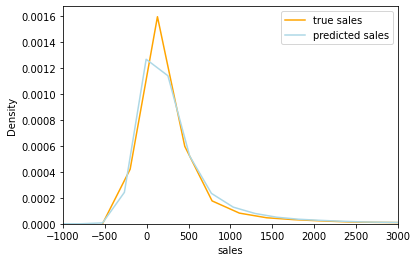

In [30]:
# validate the model
product_pred=model3.predict(product_std)
product_true=product['sales']
g=sns.kdeplot(product_true,label='true sales',color='orange')
g=sns.kdeplot(product_pred,label='predicted sales',color='lightblue')
g.set_xlim(-1000,3000)
plt.legend();

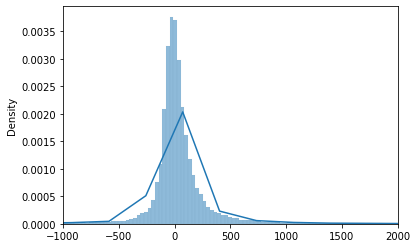

In [31]:
# plot residuals
residuals=product_pred-product_true
g=sns.histplot(residuals,stat='density',kde=True,bins=2000)
g.set_xlim(-1000,2000);

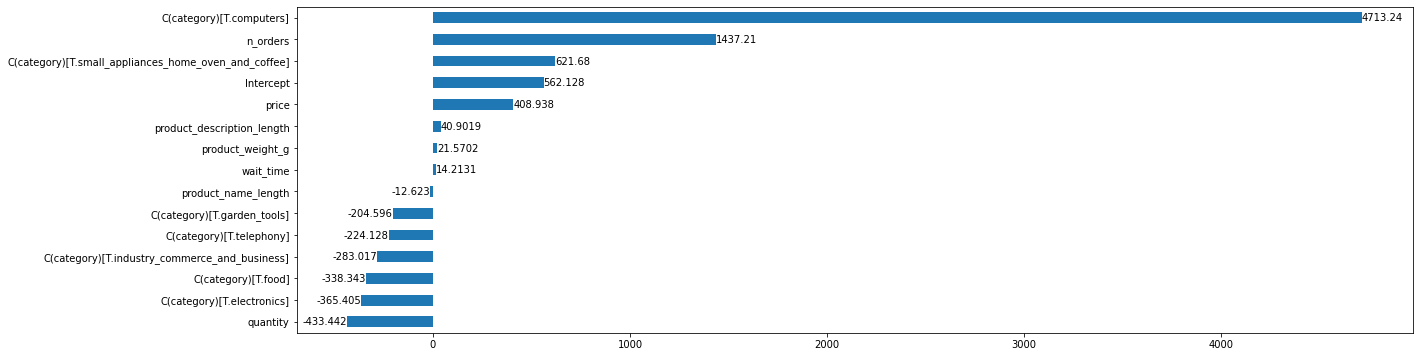

In [32]:
params=pd.concat([model3.params,model3.pvalues],axis=1)
params.columns=['coef','p-values']
# Select sigfinicant parameters 
params=params[params['p-values']<0.05]
                    
plt.figure(figsize=(20,6))
ax=params['coef'].sort_values().plot(kind='barh')
ax.bar_label(ax.containers[0]);

The most important categories are:

- computer(++)

- oven and coffee (++)

- electronics (-)

- commerce and business (-)



In [33]:
bad_cat=['electronics','food','industry_commerce_and_business','telephony','garden_tools']
bad1=product[(product['category']=='electronics')
                    & (product['profits']<0)]
bad1=bad1[['category','profits']].groupby('category').sum()

bad2=product[(product['category']=='food')
                    & (product['profits']<0)]
bad2=bad2[['category','profits']].groupby('category').sum()


bad3=product[(product['category']=='industry_commerce_and_business')
                    & (product['profits']<0)]
bad3=bad3[['category','profits']].groupby('category').sum()


bad4=product[(product['category']=='telephony')
                    & (product['profits']<0)]
bad4=bad4[['category','profits']].groupby('category').sum()

bad5=product[(product['category']=='garden_tools')
                    & (product['profits']<0)]
bad5=bad5[['category','profits']].groupby('category').sum()

improvement=pd.concat([bad1,bad2,bad3,bad4,bad5],axis=0)
improvement

improvement['improve profits by']=-improvement['profits']/total_profits
improvement.loc[len(improvement.index)] = [improvement['profits'].sum(),improvement['improve profits by'].sum()]
improvement=improvement.rename(index={4: 'sum'})
improvement['improve profits by']=improvement['improve profits by'].apply(lambda x: "{:.2%}".format(x))


In [34]:
selected_cats=['electronics','food','industry_commerce_and_business','telephony',
               'garden_tools','computers','small_appliances_home_oven_and_coffee']
improvement=pd.DataFrame()
for cat in selected_cats:
    print(cat)
    bad1=product[(product['category']==cat) & (product['profits']<0)]
    bad1=bad1[['category','profits']].groupby('category').sum()
    print(bad1)
    improvement=pd.concat([improvement,bad1],axis=0)
    

improvement['improve profits by']=-improvement['profits']/total_profits
improvement.loc[len(improvement.index)] = [improvement['profits'].sum(),improvement['improve profits by'].sum()]
improvement=improvement.rename(index={4: 'sum'})
improvement['improve profits by']=improvement['improve profits by'].apply(lambda x: "{:.2%}".format(x))
improvement

electronics
              profits
category             
electronics -6126.240
food
          profits
category         
food     -178.990
industry_commerce_and_business
Empty DataFrame
Columns: [profits]
Index: []
telephony
             profits
category            
telephony -10926.710
garden_tools
               profits
category              
garden_tools -1886.850
computers
Empty DataFrame
Columns: [profits]
Index: []
small_appliances_home_oven_and_coffee
Empty DataFrame
Columns: [profits]
Index: []


,profits,improve profits by
category,,
electronics,-6126.240,0.52%
food,-178.990,0.02%
telephony,-10926.710,0.94%
garden_tools,-1886.850,0.16%
sum,-19118.790,1.64%


In [35]:
selected_cats=['electronics','food','industry_commerce_and_business','telephony',
               'garden_tools','computers','small_appliances_home_oven_and_coffee']
improvement

,profits,improve profits by
category,,
electronics,-6126.240,0.52%
food,-178.990,0.02%
telephony,-10926.710,0.94%
garden_tools,-1886.850,0.16%
sum,-19118.790,1.64%


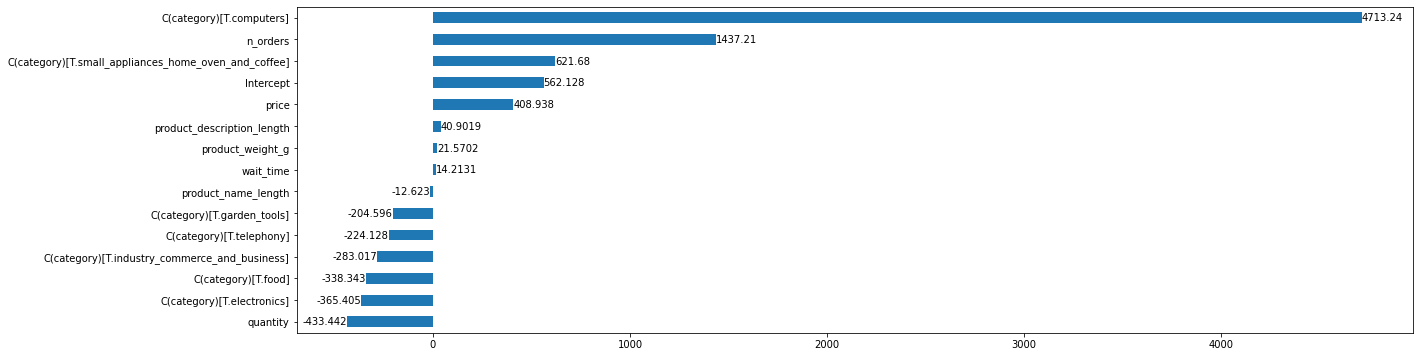

In [36]:
params=pd.concat([model3.params,model3.pvalues],axis=1)
params.columns=['coef','p-values']
# Select sigfinicant parameters 
params=params[params['p-values']<0.05]
                    
plt.figure(figsize=(20,6))
ax=params['coef'].sort_values().plot(kind='barh')
ax.bar_label(ax.containers[0]);

Neither does Computers nor small_appliances_home_oven_and_coffee have negative-product.

In [37]:
#Popular categories
selected=product[['category','n_orders','profits','sales','IT_costs']].groupby('category').sum()\
.sort_values(by='profits',ascending=False)
selected.head()

,n_orders,profits,sales,IT_costs
category,,,,
health_beauty,8962,1123072.280,1251312.280,3664.051
watches_gifts,5761,1090103.570,1187783.570,2084.626
sports_leisure,7798,862378.150,976548.150,4073.098
bed_bath_table,10101,828874.980,1030834.980,4517.758
computers_accessories,6840,776655.740,899465.740,2610.813


Neither is Computers nor small_appliances_home_oven_and_coffee is among the popular categories.

In [38]:
sorted_product=product.sort_values(by='profits',ascending=True)
get_rid_of=[500,1000,1500,2000,2500,3000,4000]
improvement=pd.DataFrame()

total_sales=product['sales'].sum()
total_orders=product['n_orders'].sum()
#total_IT=product['IT_costs'].sum()

for num in get_rid_of:
    #print(cat)
    bad=sorted_product[['profits','sales','n_orders']].head(num).sum()
    #bad=sorted_product.head(num).sum()
    improvement=pd.concat([improvement,bad],axis=1)
    improvement=improvement.rename(columns={0:num})
improvement=improvement.T
improvement['profits']=improvement['profits']/total_profits
improvement['sales']=improvement['sales']/total_sales
improvement['n_orders']=improvement['n_orders']/total_orders
improvement=improvement.rename(columns={'n_orders':'volumes_reduced'})

improvement=improvement.applymap(lambda x: "{:.2%}".format(-x))

In [39]:
get_rid_of=[500,1000,1500,2000,2500,3000,4000]
improvement

,profits,sales,volumes_reduced
500,4.98%,-0.33%,-2.02%
1000,7.58%,-0.54%,-2.99%
1500,9.17%,-0.79%,-3.92%
2000,10.07%,-1.03%,-4.84%
2500,10.39%,-1.31%,-5.81%
3000,10.20%,-1.55%,-6.65%
4000,8.98%,-1.84%,-8.03%


### Conclusions:

- Computer and small_appliances_home_oven_and_coffee have highest impact on sales, and neither contains any negative-profit products. Surprisingly, neither is among the biggest contributors to the profits. Boost sales in these two categories may be very beneficial. 


- Remove products if necessary. 

   -Removing products from high-impact categories is not enough. Removing the worst 2000-3000 products may help improve the profit by 10%, it might be more conservative compared to removing sellers based on the volumes_reduced. Removal may be helpful in improving reviews scores and IT_costs, more analysis is needed for this.
   
   -We do not know how cost are allocated within the same orders (we assumed all products within the same order share equal (full) responsibilities to the cost_of_review of that order). Such detailed information would be helpful for us to identify bad products.


# Action 3 : restrict selling between customer-seller states: (AM, CE)	


In [42]:
# Get customer data
# returns: order_id, customer_id,customer_state
customers=Olist().get_data()['customers'][['customer_id','customer_state']].drop_duplicates()
#customers.columns
orders=Olist().get_data()['orders'][['customer_id','order_id']].drop_duplicates()
customers=customers.merge(orders,on='customer_id',how='inner')

# Get customer data
# returns: order_id, seller_id,seller_state
sellers=Olist().get_data()['sellers'][['seller_id','seller_state']].drop_duplicates()
order_items=Olist().get_data()['order_items'][['order_id','seller_id']].drop_duplicates()
sellers=sellers.merge(order_items,on='seller_id',how='inner').drop_duplicates()

In [51]:
order=Order().get_training_data()
order.head()

KeyError: 'order_id'

# Thank you!